In [135]:
import matplotlib
%matplotlib qt5

from pylab import show, ginput, rand, imshow, plot, imread
from matplotlib.figure import Figure
import numpy as np

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import os
from pylab import plot, ginput, show, axis
from scipy.spatial import Delaunay
from skimage.draw import polygon

In [2]:
def display_image(image, display=True, addIntDisplay=False):
    if display and addIntDisplay:
        display_image_with_int(image)
        plt.show()
    if display:
        imshow(image)
        plt.show()

In [3]:
def display_image_with_int(image):
    imshow(image.astype(np.uint8))
    plt.show()

In [4]:
import imageio

def save_gif_stack(images, file_to='', output_path="output/"):
    if file_to:
        imageio.mimsave(output_path + file_to, images)

In [133]:
def save_image(image, file_to='', output_path="output/"):
    if file_to:
        imageio.imwrite(output_path + file_to, image)

In [134]:
import skimage.io as skio

def pick_points(image, already_saved_at='', saveAs='', num_pts=58):
    if already_saved_at and os.path.isfile("data/" + already_saved_at): 
        return np.loadtxt("data/" + already_saved_at) 
    else: 
        skio.imshow(image)
        pts = np.array(ginput(num_pts, timeout=600))
        if already_saved_at: 
            np.savetxt("data/" + already_saved_at, pts)
        elif saveAs: 
            np.savetxt("data/" + saveAs, pts)
        return pts

## Defining Correspondences:

In [150]:
import matplotlib
%matplotlib qt5
# %matplotlib inline
ross = imread('data/david.jpg')
ross_face_pts = pick_points(ross, already_saved_at='ross.txt')

In [151]:
import matplotlib
%matplotlib qt5
george = imread('data/george_small.jpg')
george_face_pts = pick_points(george, already_saved_at='george.txt')

## Triangulation:

In [152]:
def generate_triangulation(tri_points, image=None, display=True, addIntDisplay=False):
    tri = Delaunay(tri_points)
    if display and image is not None:
        skio.imshow(image)
    if display and addIntDisplay:
        display_image_with_int(image)
    if display:
        plt.triplot(tri_points[:,0], tri_points[:,1], tri.simplices)
        plt.plot(tri_points[:,0], tri_points[:,1], 'o')
        plt.show()
    return tri

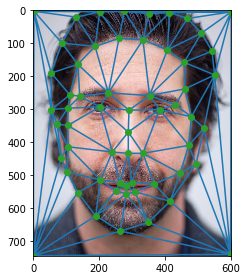

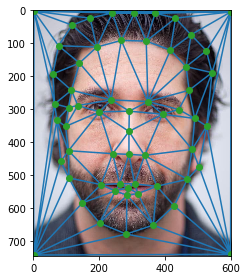

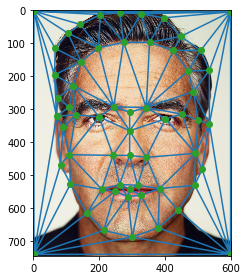

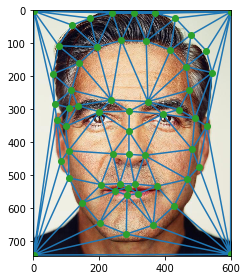

In [153]:
%matplotlib inline

#Generating average triangulation 
mean_goerge_ross = np.mean(np.array([ross_face_pts, george_face_pts]), axis=0)

tri_ross = generate_triangulation(ross_face_pts, ross, display= True)
generate_triangulation(mean_goerge_ross, ross, display= True)

tri_george = generate_triangulation(george_face_pts, george, display= True)
tri_mean_george_ross = generate_triangulation(mean_goerge_ross, george, display= True)

## Computing the "Mid-way Face" :

In [154]:
def computeAffine(tri_source, tri_dest):
    row_ones = np.ones((3,1))
    source_pts = np.hstack([tri_source, row_ones]).T
    dest_pts = np.hstack([tri_dest, row_ones]).T
    
    return np.dot(dest_pts, np.linalg.inv(source_pts))

In [155]:
import skimage
from skimage.draw import polygon
%matplotlib inline
              
def warp_image(s_image, dest_pts, source_pts, tri, display=False, displayStack=False, addIntDisplay=False, saveAs=""):
    #creating a dummy image full of zeros
    dummy_im = np.zeros(s_image.shape)

    for index in range(len(tri.simplices)):
        tri_pts = tri.simplices[index]
        
        tri_source = source_pts[tri_pts]
        tri_dest = dest_pts[tri_pts]

        affine_matrix = computeAffine(tri_source,tri_dest)
        affine_inv = np.linalg.inv(affine_matrix)
        
        dum_row, dum_col = skimage.draw.polygon(tri_dest[:, 0], tri_dest[:, 1]) 
        row_ones = np.ones(len(dum_col))
        dummy_pts = np.vstack([dum_row, dum_col, row_ones]).astype(int)
        
        source_pts_selected = np.dot(affine_inv, dummy_pts)
        s_r, s_c, _ = np.round(source_pts_selected).astype(int)

        dummy_im[dum_col, dum_row] = s_image[s_c, s_r]
    
    display_image(s_image, display, addIntDisplay)
    display_image(dummy_im, display, addIntDisplay)

    save_image(dummy_im, saveAs)
    return dummy_im


In [156]:
def compute_midway(source_im, source_pts, dest_im, dest_pts, factor=0.5, display=False, addIntDisplay=False, displayStack=False, saveAs=''):
    mean_pts = (1 - factor) * np.array(source_pts) + factor * np.array(dest_pts)
    tri_mean = generate_triangulation(mean_pts,display=False)
    
    source_warp = warp_image(source_im, mean_pts, source_pts, tri_mean, display=display) 
    dest_warp = warp_image(dest_im, mean_pts, dest_pts, tri_mean, display=display)  

    morphed_im = cross_dissolve(source_warp, dest_warp, a1=factor, a2 = 1-factor, display=display, saveAs=saveAs)
    
    return [source_warp, dest_warp, morphed_im]

In [157]:
def cross_dissolve(imageOne, imageTwo, a1, a2, display = True, addIntDisplay=False,saveAs=""):
    avg = a1*imageOne + a2*imageTwo
    display_image(avg, display, addIntDisplay=addIntDisplay)
    save_image(avg, saveAs)
    return avg

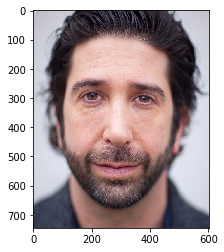

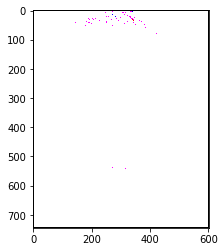

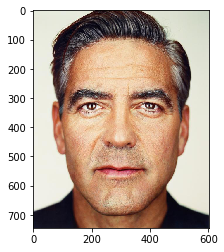

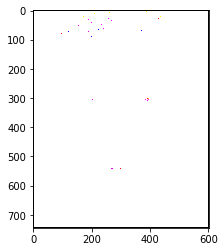

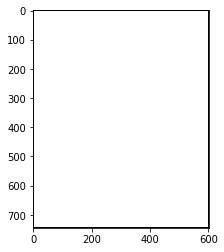

In [163]:
ross_warp, george_warp, ross_goerge = compute_midway(ross.astype(np.uint8), ross_face_pts, george.astype(np.uint8), george_face_pts, factor=0.5, display=True, displayStack=True, addIntDisplay=True, saveAs='')


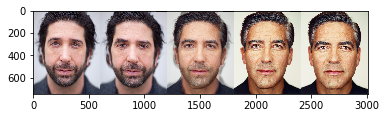

In [166]:
display_image(np.hstack([ross.astype(np.uint8), ross_warp.astype(np.uint8), ross_goerge.astype(np.uint8), george_warp.astype(np.uint8), george.astype(np.uint8)]), display=True)

save_image(np.hstack([ross.astype(np.uint8), ross_warp.astype(np.uint8), ross_goerge.astype(np.uint8), george_warp.astype(np.uint8), george.astype(np.uint8)]), file_to ="stack_morph.jpg")




## The Morph Sequence

In [70]:
def morph(im1, im2, im1_pts, im2_pts, warp_frac, dissolve_frac, display = True, addIntDisplay = False):
    mean_curr = warp_frac*np.array(im1_pts) + (1-warp_frac)*np.array(im2_pts)
    tri = generate_triangulation(mean_curr, display=False, addIntDisplay=addIntDisplay)
    
    mean_warp_image1 = warp_image(im1, mean_curr, im1_pts, tri)
    mean_warp_image2 = warp_image(im2, mean_curr, im2_pts, tri)
    f = cross_dissolve(mean_warp_image1, mean_warp_image2, dissolve_frac, 1 - dissolve_frac, display=display,addIntDisplay=addIntDisplay)
    return f

In [18]:
def create_morph(image1, image1_pts, image2, image2_pts, display=True, addIntDisplay=False):
    faces = []
    counter = 0
    for counter in np.linspace(0, 1, 25):
        a1 = counter
        a2 = 1 - a1
        f = morph(image1, image2, image1_pts, image2_pts, a1, a1, display=display, addIntDisplay=addIntDisplay)
        faces += [f]
    return faces

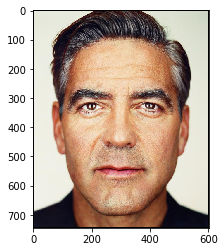

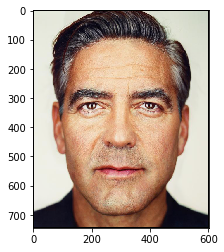

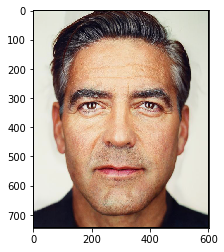

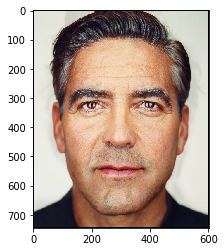

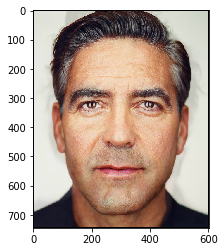

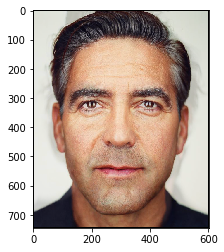

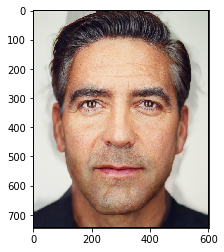

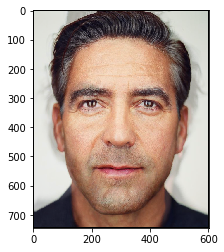

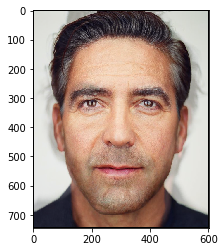

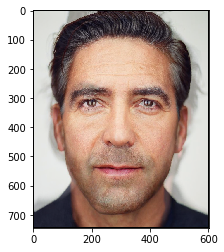

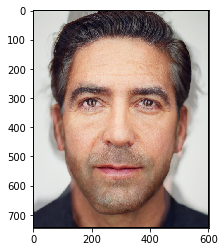

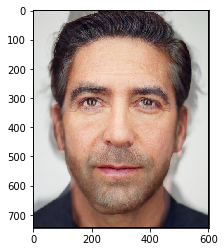

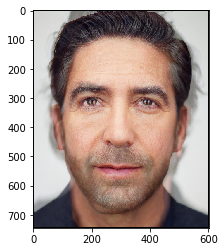

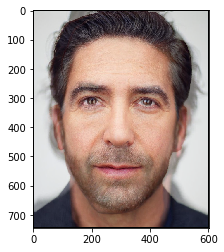

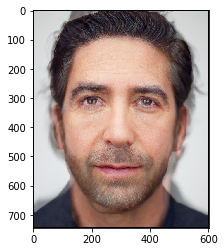

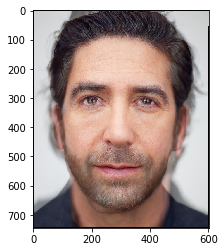

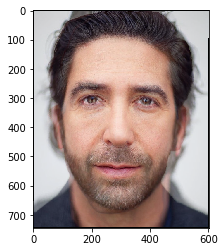

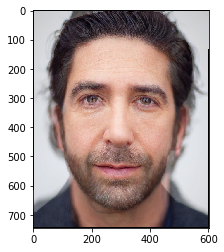

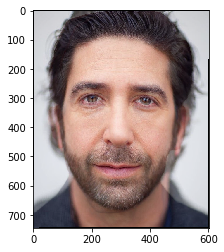

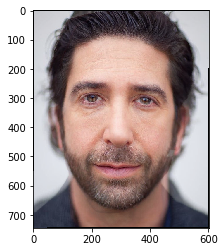

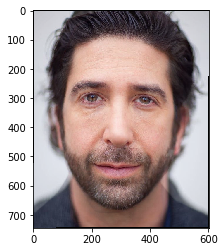

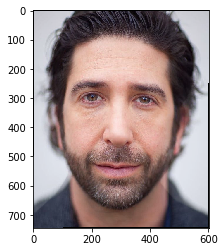

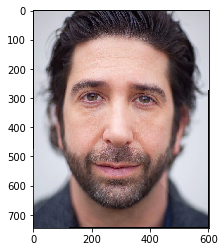

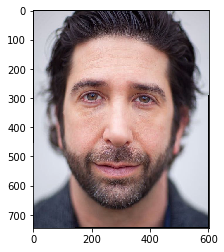

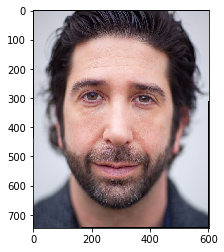

In [19]:
faces = create_morph(ross, ross_face_pts, george, george_face_pts)

In [26]:
save_gif_stack(faces, "goerge_ross.gif")

## The "Mean face" of a population


In [20]:
def read_asf(image, file_name):
    f = open(file_name, "r")
    all_lines = f.readlines()
    image_pts = []
    row_len = image.shape[1]
    col_len = image.shape[0]
    for ind in range(16, 74):
        row = row_len*float(all_lines[ind].split('\t')[2])
        col = col_len*float(all_lines[ind].split('\t')[3])
        image_pts += [[row,col]]
    
    image_pts += [[0,0]]
    image_pts += [[0,col_len]]
    image_pts += [[row_len,0]]
    image_pts += [[row_len,col_len]]
    return np.array(image_pts)

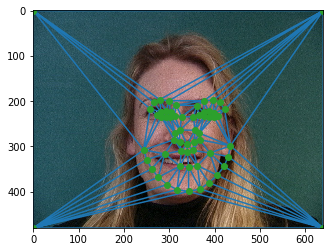

In [21]:
%matplotlib inline
one = imread('data/danes/08-2f.jpg')
one_pts = read_asf(one, "data/danes/08-2f.asf")

two = imread('data/danes/12-2f.jpg')
two_pts = read_asf(two, "data/danes/12-2f.asf")
three = imread('data/danes/14-2f.jpg')
three_pts = read_asf(three, 'data/danes/14-2f.asf')

four = imread('data/danes/15-2f.jpg')
four_pts = read_asf(four, "data/danes/15-2f.asf")

five = imread('data/danes/22-2f.jpg')
five_pts = read_asf(five, "data/danes/22-2f.asf")

six = imread('data/danes/30-2f.jpg')
six_pts = read_asf(six, "data/danes/30-2f.asf")

seven = imread('data/danes/35-2f.jpg')
seven_pts = read_asf(seven, "data/danes/35-2f.asf")

danes_faces = np.array([one_pts, two_pts, three_pts, four_pts, five_pts, six_pts, seven_pts])
mean_danes = np.mean(danes_faces, axis=0)
tri_mean_danes = Delaunay(mean_danes)
plt.triplot(mean_danes[:,0], mean_danes[:,1], tri_mean_danes.simplices)
plt.plot(mean_danes[:,0], mean_danes[:,1], 'o')
imshow(seven)
plt.show()


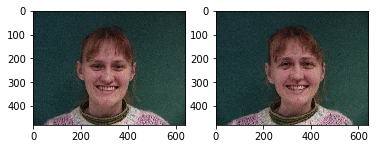

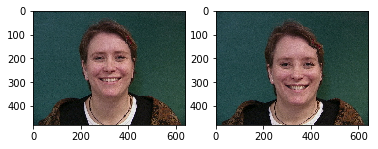

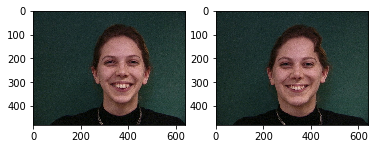

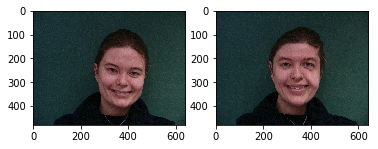

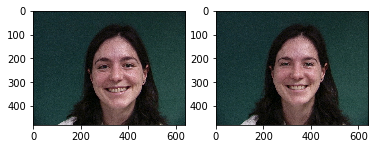

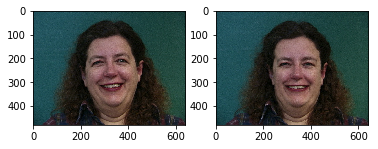

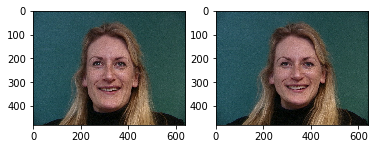

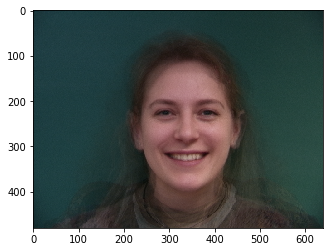

In [22]:
warped_one = warp_image(one, mean_danes, one_pts, tri_mean_danes)
warped_two = warp_image(two, mean_danes, two_pts, tri_mean_danes)
warped_three = warp_image(three, mean_danes, three_pts, tri_mean_danes)
warped_four = warp_image(four, mean_danes, four_pts, tri_mean_danes)
warped_five = warp_image(five, mean_danes, five_pts, tri_mean_danes)
warped_six = warp_image(six, mean_danes, six_pts, tri_mean_danes)
warped_seven = warp_image(seven, mean_danes, seven_pts, tri_mean_danes)

morphed_images = [warped_one, warped_two, warped_three, warped_four, warped_five, warped_six, warped_seven]

fig, ax = plt.subplots(1,2)
ax[0].imshow(one)
ax[1].imshow(warped_one.astype(np.uint8))

fig, ax = plt.subplots(1,2)
ax[0].imshow(two)
ax[1].imshow(warped_two.astype(np.uint8))

fig, ax = plt.subplots(1,2)
ax[0].imshow(three)
ax[1].imshow(warped_three.astype(np.uint8))

fig, ax = plt.subplots(1,2)
ax[0].imshow(four)
ax[1].imshow(warped_four.astype(np.uint8))

fig, ax = plt.subplots(1,2)
ax[0].imshow(five)
ax[1].imshow(warped_five.astype(np.uint8))

fig, ax = plt.subplots(1,2)
ax[0].imshow(six.astype(np.uint8))
ax[1].imshow(warped_six.astype(np.uint8))

fig, ax = plt.subplots(1,2)
ax[0].imshow(seven)
ax[1].imshow(warped_seven.astype(np.uint8))

fig, ax = plt.subplots(1,1)
morphed_pop = np.average(morphed_images,axis=0)
plt.imshow(morphed_pop.astype(np.uint8))

In [23]:
save_image(warped_one, "warped_one.jpg")
save_image(warped_two, "warped_two.jpg")
save_image(warped_three, "warped_three.jpg")
save_image(warped_four, "warped_four.jpg")
save_image(warped_five, "warped_five.jpg")
save_image(warped_six, "warped_six.jpg")
save_image(warped_seven, "warped_seven.jpg")
save_image(morphed_pop, "morphed_pop.jpg")

In [132]:
import matplotlib
%matplotlib qt5

#%matplotlib inline

chetana = imread('data/chetana_green.jpg')
chetana_face_pts = pick_points(chetana, already_saved_at='chetana_green.txt')


In [26]:
import matplotlib
%matplotlib qt5

# %matplotlib inline

morphed_pop_pts = pick_points(morphed_pop, already_saved_at='morphed_pop.txt')


In [27]:
%matplotlib inline

#Generating average triangulation 
mean_chetana_morph = np.mean(np.array([chetana_face_pts, morphed_pop_pts]), axis=0)

#Generating triangulation for Chetana
tri_chetana = generate_triangulation(chetana_face_pts, chetana, display= False)

#displaying average triangulation on Chetana
generate_triangulation(mean_chetana_morph, chetana, display= False)

#Generating triangulation for population
tri_pop = generate_triangulation(morphed_pop_pts, morphed_pop, display= False, addIntDisplay=False)

#displaying average triangulation on population avg
tri_mean_chet_pop = generate_triangulation(mean_chetana_morph, morphed_pop, display= False, addIntDisplay=False)

chet_warp, pop_warp, chet_pop = compute_midway(chetana, chetana_face_pts, morphed_pop, morphed_pop_pts, factor=0.5, display=False, displayStack=False, addIntDisplay=False, saveAs='')



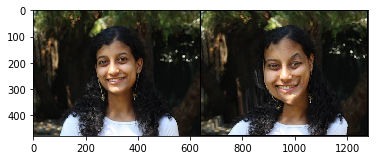

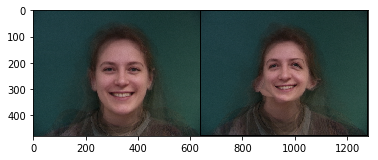

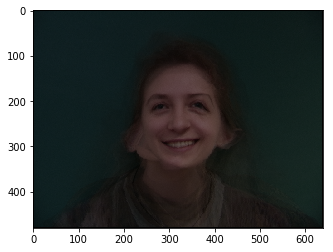

In [28]:
display_image(np.hstack([chetana,chet_warp]), display = True)
save_image(np.hstack([chetana,chet_warp]), file_to='chetana_warp.jpg')

display_image(np.hstack([morphed_pop.astype(np.uint8), pop_warp.astype(np.uint8)]), display = True)
save_image(np.hstack([morphed_pop.astype(np.uint8), pop_warp.astype(np.uint8)]), file_to='pop_warp.jpg')

display_image(chet_pop.astype(np.uint8), display=True)
save_image(chet_pop, file_to='chet-pop.jpg')

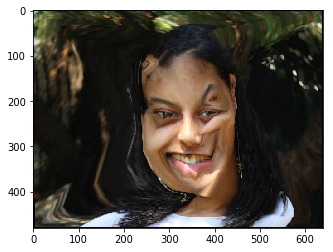

In [29]:
%matplotlib inline

factor = -0.1

car_avg = factor*chetana_face_pts + (1-factor)*morphed_pop_pts

tri_mean_car = Delaunay(car_avg)
    
warped_chetana_car = warp_image(chetana, car_avg, chetana_face_pts, tri_mean_car)
warped_morph_pop_car = warp_image(morphed_pop.astype(np.uint8), car_avg, morphed_pop_pts, tri_mean_car)

display_image(warped_chetana_car)


In [30]:
save_image(warped_chetana_car, "warped_chetana_car.jpg")

## Extra credit


In [58]:
import matplotlib
%matplotlib qt5

#%matplotlib inline

chetana_ec = imread("data/chetanaramaiyer.jpg")

# chetana_ec_pts = pick_points(chetana_ec, saveAs='chetana_ec.txt')

chetana_ec_pts = pick_points(chetana_ec, already_saved_at='chetana_ec.txt')


In [59]:
import matplotlib
%matplotlib qt5
# %matplotlib inline

richard = imread("data/image6.jpg")

# richard_ec_pts = pick_points(richard, saveAs='richard.txt')

richard_ec_pts = pick_points(richard, already_saved_at='richard.txt')


In [60]:
%matplotlib inline

mean_chetana_rich = np.mean(np.array([chetana_ec_pts, richard_ec_pts]), axis=0)

tri_chetana = generate_triangulation(chetana_ec_pts, chetana_ec, display= False)

generate_triangulation(mean_chetana_rich, chetana_ec, display= False)

tri_pop = generate_triangulation(richard_ec_pts, richard, display= False, addIntDisplay=False)

tri_mean_chet_rich = generate_triangulation(mean_chetana_rich, richard, display= False, addIntDisplay=False)

chet_ec_warp, rich_warp, chet_rich = compute_midway(chetana_ec, chetana_ec_pts, richard, richard_ec_pts, factor=0.5, display=False, displayStack=False, addIntDisplay=False, saveAs='')



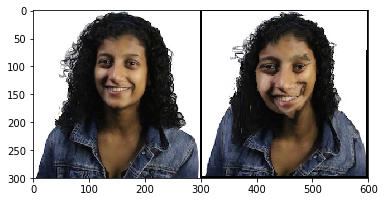

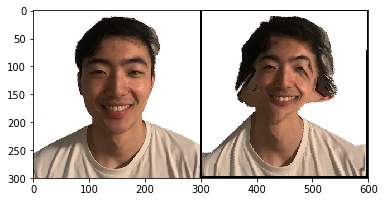

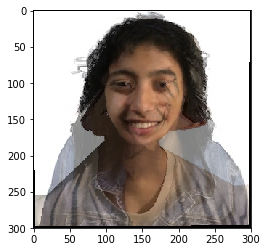

In [63]:
display_image(np.hstack([chetana_ec.astype(np.uint8),chet_ec_warp.astype(np.uint8)]), display = True)
save_image(np.hstack([chetana_ec.astype(np.uint8),chet_ec_warp.astype(np.uint8)]), file_to='chetana_ec_warp.jpg')

display_image(np.hstack([richard.astype(np.uint8), rich_warp.astype(np.uint8)]), display = True)
save_image(np.hstack([richard.astype(np.uint8), rich_warp.astype(np.uint8)]), file_to='rich_warp.jpg')

display_image(chet_rich.astype(np.uint8), display=True)
save_image(chet_rich.astype(np.uint8), file_to='chet-rich.jpg')

In [71]:
faces = create_morph(chetana_ec.astype(np.uint8), chetana_ec_pts, richard.astype(np.uint8), richard_ec_pts, display=False, addIntDisplay=False)


In [67]:
save_gif_stack(faces, file_to="chet_rich_temp.gif")

## Having fun with morphing

In [100]:
import matplotlib
%matplotlib qt5

# %matplotlib inline

joey = imread("data/joey.jpg")

joey_pts = pick_points(joey, saveAs='joey.txt')

# joey_pts = pick_points(joey, already_saved_at='joey.txt')

# joey_pts = pick_points_from_saved(joey, joey_pts, already_saved_at='joey.txt')


In [101]:
import matplotlib
%matplotlib qt5

# %matplotlib inline

nick = imread("data/nick.jpg")

nick_pts = pick_points(nick, saveAs='nick.txt')

# nick_pts = pick_points(nick, already_saved_at='nick.txt')

# nick_pts = pick_points_from_saved(nick, nick_pts, already_saved_at='nick.txt')


In [104]:
nick_pts

array([[4.48304792e+02, 4.16107648e+02],
       [4.41055726e+02, 4.74100173e+02],
       [4.31994394e+02, 5.32092699e+02],
       [3.79438668e+02, 5.15782301e+02],
       [4.64615189e+02, 5.19406834e+02],
       [3.41381073e+02, 3.90735918e+02],
       [5.33481313e+02, 4.05234049e+02],
       [2.87013081e+02, 3.36367926e+02],
       [3.37756540e+02, 3.27306594e+02],
       [3.70377336e+02, 3.43616991e+02],
       [5.11734116e+02, 3.59927389e+02],
       [5.66102109e+02, 3.43616991e+02],
       [5.98722904e+02, 3.63551922e+02],
       [3.32319741e+02, 5.82836158e+02],
       [3.81250934e+02, 5.66525760e+02],
       [4.21120795e+02, 5.79211625e+02],
       [4.50117058e+02, 5.81023892e+02],
       [4.79113321e+02, 6.10020154e+02],
       [3.77626402e+02, 5.99146556e+02],
       [4.21120795e+02, 5.99146556e+02],
       [4.51929325e+02, 6.06395622e+02],
       [2.29020555e+02, 2.83812200e+02],
       [2.76139482e+02, 1.96823412e+02],
       [3.57691471e+02, 2.04072477e+02],
       [4.247453

In [105]:
%matplotlib inline

mean_joey_nick = np.mean(np.array([joey_pts, nick_pts]), axis=0)

chet_ec_warp, rich_warp, chet_rich = compute_midway(joey, joey_pts, nick, nick_pts, factor=0.5, display=False, displayStack=False, addIntDisplay=False, saveAs='')



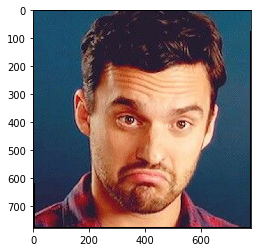

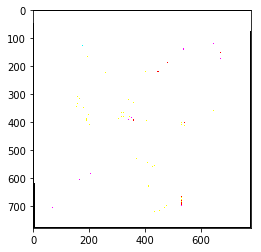

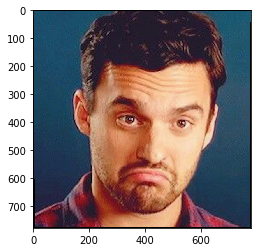

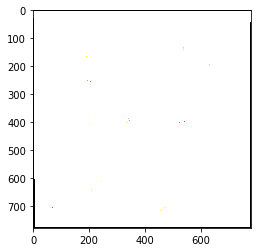

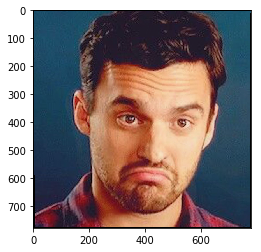

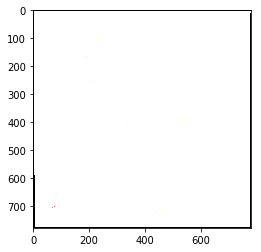

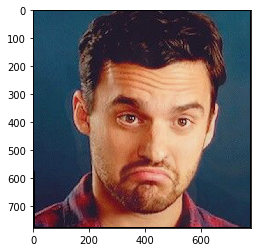

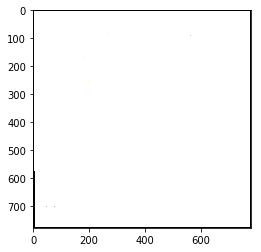

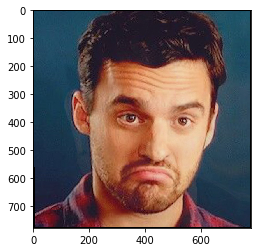

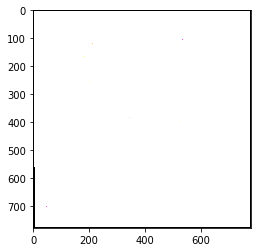

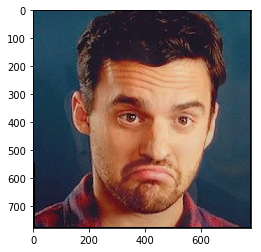

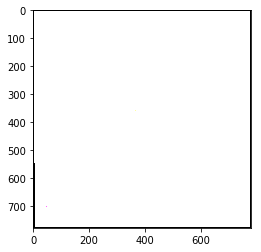

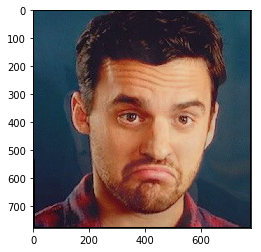

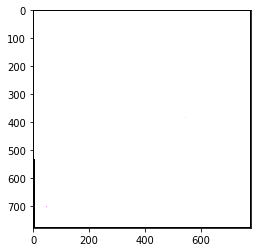

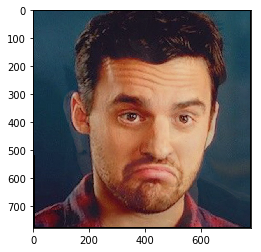

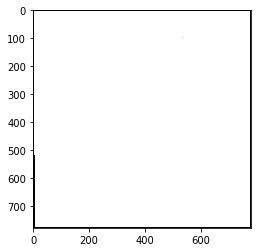

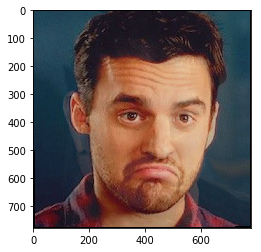

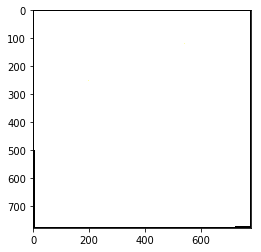

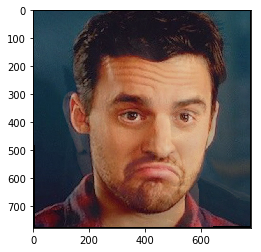

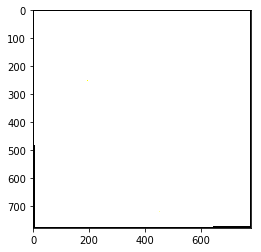

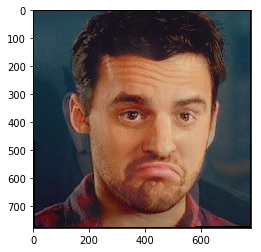

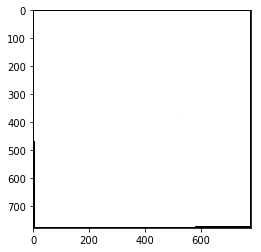

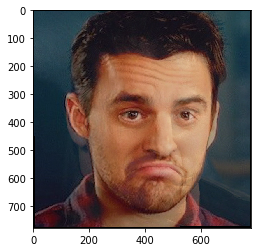

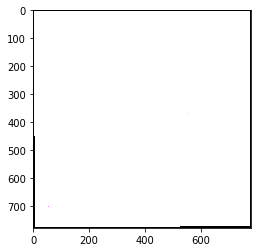

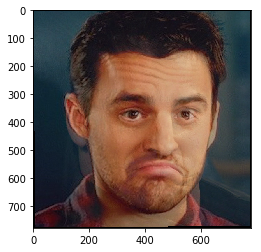

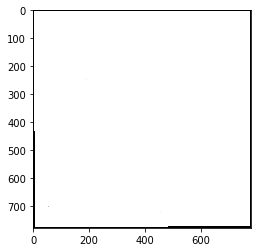

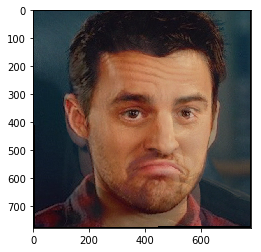

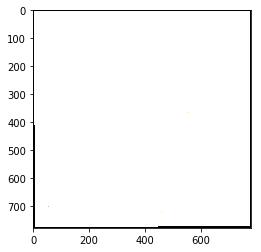

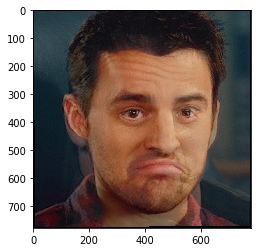

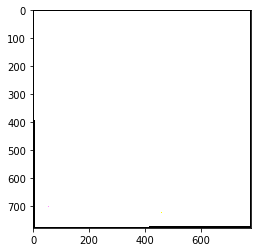

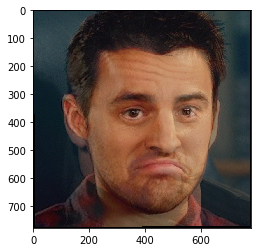

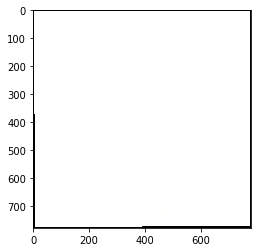

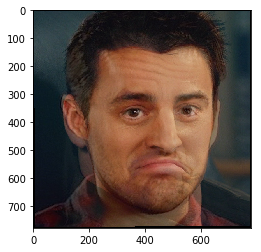

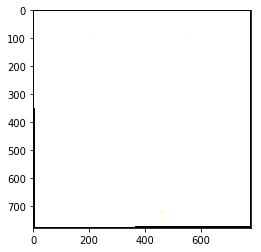

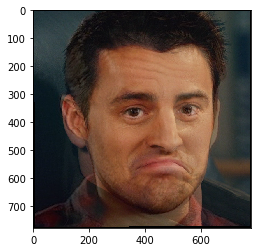

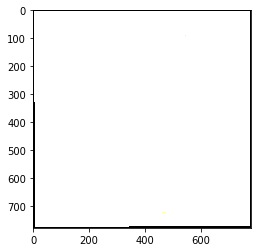

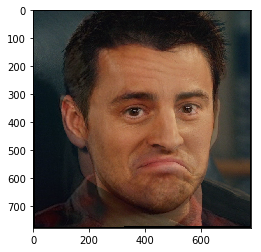

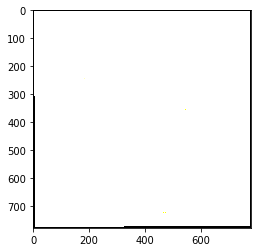

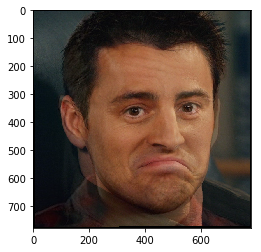

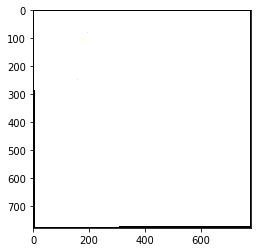

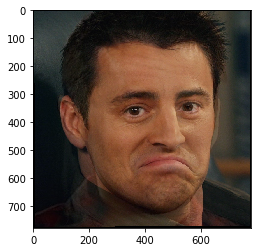

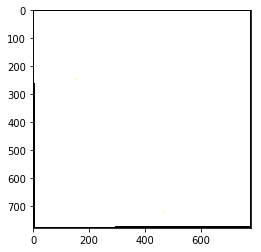

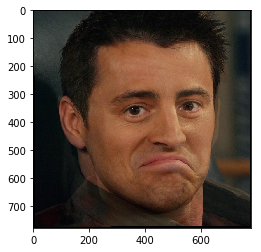

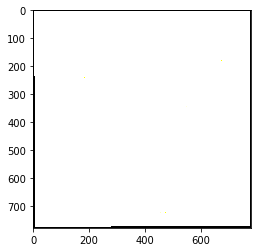

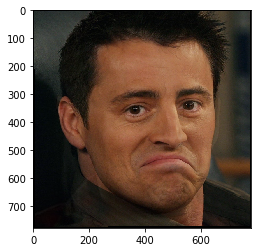

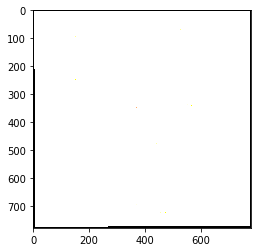

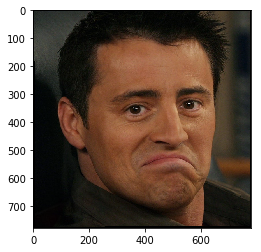

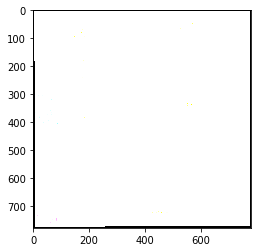

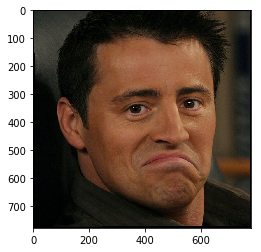

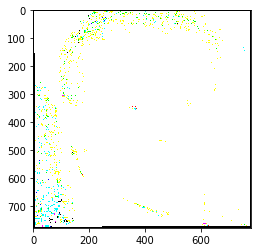

In [109]:
faces = create_morph(joey, joey_pts, nick, nick_pts, display=True, addIntDisplay=True)


In [111]:
save_gif_stack(faces, file_to="joey_nick.gif")